# RNN — BIBO Stability & Transfer-Function View (Basic + Intermediate)

This notebook focuses only on how **BIBO stability** and **transfer-function** thinking apply to linearized RNNs. No ML training, optimizers, or deep network theory — just discrete-time dynamical systems, stability, and plots.

**Contents**

- Quick summary
- Imports and helper utilities
- Section 1: Stability classification (spectral radius)
- Section 2: Hidden state evolution (homogeneous system)
- Section 3: Impulse response
- Section 4: Transfer function (Z-domain) and frequency response
- Section 5: Spectral radius sweep (stability boundary)
- Section 6: Vanishing / exploding gradient analysis
- Section 7: Small parameter study showing all behaviors
- Section 8: Numerical checks for BIBO stability (practical tests)
- Section 9: Optional short nonlinear activation demonstration
- Section 10: Conclusion 

Run the cells in order. The notebook uses only `numpy`, `scipy`, and `matplotlib`.

## Quick summary (TL;DR)

- A linearized RNN around an equilibrium behaves as: $h_{t+1}=A h_t + B x_t$.
- Transfer function (Z-domain): $T(z)=C (zI - A)^{-1} B$ for output $y_t = C h_t$.
- **BIBO stable** iff all eigenvalues of $A$ lie strictly inside the unit circle ($\rho(A)<1$).
- Impulse response: $h_t = A^t B$ (for zero initial state and impulse input).
- Gradients behave like powers of $A^\top$; spectral radius controls vanishing/exploding behaviour.


In [2]:
# Imports and helper utilities
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigvals, norm, inv
from scipy.linalg import eig
plt.rcParams.update({"figure.figsize": (8,4), "font.size": 12})

def spectral_radius(A):
    eigs = eigvals(A)
    return float(np.max(np.abs(eigs))), eigs

def simulate_homogeneous(A, h0, steps=50):
    h = h0.copy()
    traj = [h.copy()]
    for _ in range(steps):
        h = A @ h
        traj.append(h.copy())
    return np.array(traj)

def impulse_response(A, B, steps=50):
    # returns sequence h_t = A^t B for t=0..steps
    H = []
    At = np.eye(A.shape[0])
    for t in range(steps+1):
        H.append(At @ B)
        At = At @ A
    return np.array(H)

def traj_norms(traj):
    return np.linalg.norm(traj, axis=1)

def plot_eigenvalues(eigs, title=None):
    plt.figure()
    plt.axvline(0, color='lightgray')
    plt.axhline(0, color='lightgray')
    theta = np.linspace(0,2*np.pi,400)
    plt.plot(np.cos(theta), np.sin(theta), '--', linewidth=0.8)
    plt.scatter(eigs.real, eigs.imag, s=80)
    plt.gca().set_aspect('equal', 'box')
    if title:
        plt.title(title)
    plt.xlabel('Real')
    plt.ylabel('Imag')
    plt.show()


## Section 1 — Simple classification of stability

Given a matrix `A`, compute eigenvalues and spectral radius and classify:

- `Stable` if rho(A) < 1
- `Marginal` if rho(A) == 1 (within numerical tol)
- `Unstable` if rho(A) > 1


Stable example: class=Stable, spectral_radius=0.6732, eigenvalues=[0.6732 0.3268]


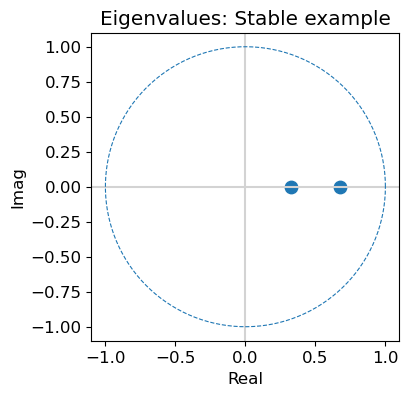

Marginal-like example (scaled): class=Marginal, spectral_radius=1.0000, eigenvalues=[0.9487+0.3162j 0.9487-0.3162j]


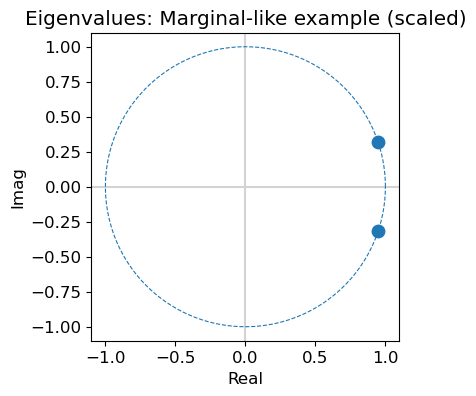

Unstable example: class=Unstable, spectral_radius=1.2000, eigenvalues=[1.2 1.1]


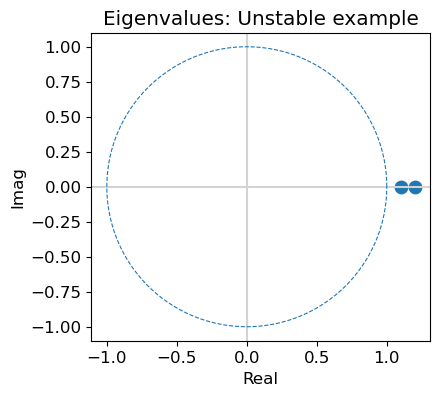

In [3]:
def classify_stability(A, tol=1e-12):
    rho, eigs = spectral_radius(A)
    if rho < 1 - tol:
        return 'Stable', rho, eigs
    elif abs(rho - 1.0) <= tol:
        return 'Marginal', rho, eigs
    else:
        return 'Unstable', rho, eigs

# Example matrices
A_stable = np.array([[0.6, 0.2], [0.1, 0.4]])
# create a marginal-like matrix by scaling a rotation-like block to radius ~1
rot = np.array([[0.9, 0.3], [-0.3, 0.9]])
A_marginal = rot / np.max(np.abs(eigvals(rot)))
A_unstable = np.array([[1.2, 0.3], [0.0, 1.1]])

for name, A in [('Stable example', A_stable), ('Marginal-like example (scaled)', A_marginal), ('Unstable example', A_unstable)]:
    cls, rho, eigs = classify_stability(A)
    print(f"{name}: class={cls}, spectral_radius={rho:.4f}, eigenvalues={np.round(eigs,4)}")
    plot_eigenvalues(eigs, title=f"Eigenvalues: {name}")


## Section 2 — Hidden state evolution (homogeneous system)

We simulate $h_{t+1}=A h_t$ (no input) from a variety of initial conditions and plot $\|h_t\|$.

Stable A trajectories: (should decay)


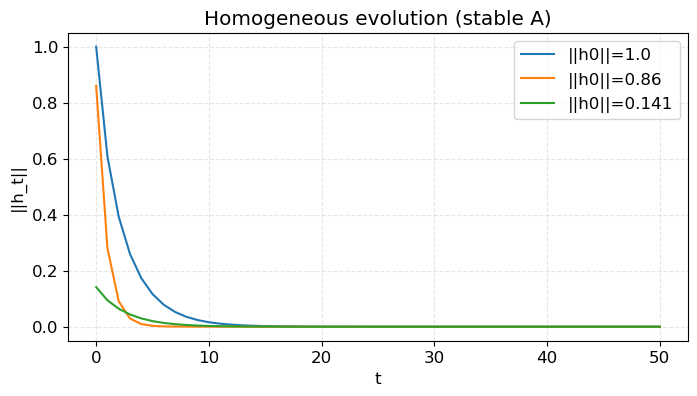

Unstable A trajectories: (should explode)


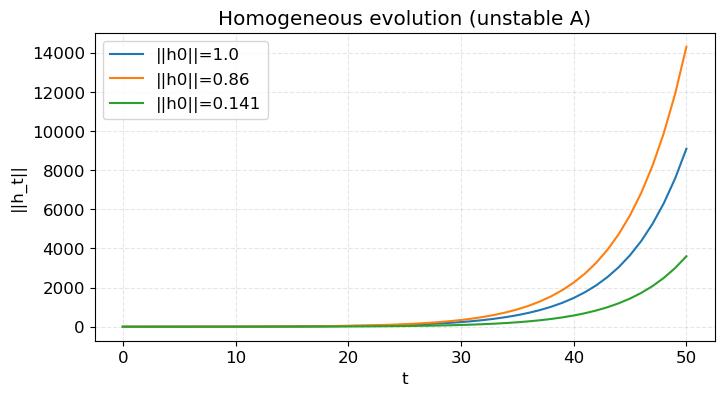

In [4]:
def run_and_plot_homogeneous(A, h0_list, steps=50, title=None):
    plt.figure()
    for h0 in h0_list:
        traj = simulate_homogeneous(A, h0, steps=steps)
        plt.plot(traj_norms(traj), label=f'||h0||={np.round(norm(h0),3)}')
    plt.yscale('linear')
    plt.xlabel('t')
    plt.ylabel('||h_t||')
    if title:
        plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.show()

h0s = [np.array([1.0, 0.0]), np.array([0.5, -0.7]), np.array([0.1, 0.1])]
print('Stable A trajectories: (should decay)') 
run_and_plot_homogeneous(A_stable, h0s, steps=50, title='Homogeneous evolution (stable A)')
print('Unstable A trajectories: (should explode)')
run_and_plot_homogeneous(A_unstable, h0s, steps=50, title='Homogeneous evolution (unstable A)')


## Section 3 — Impulse response of linearized RNN

Consider $h_{t+1}=A h_t + B x_t$ with initial state zero. If input is impulse at t=0, then $h_t = A^t B$.


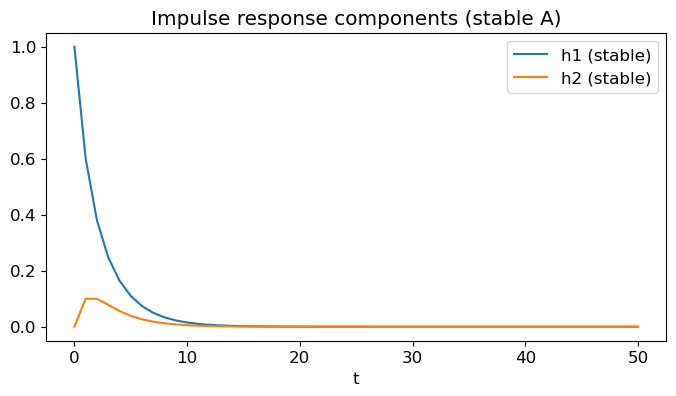

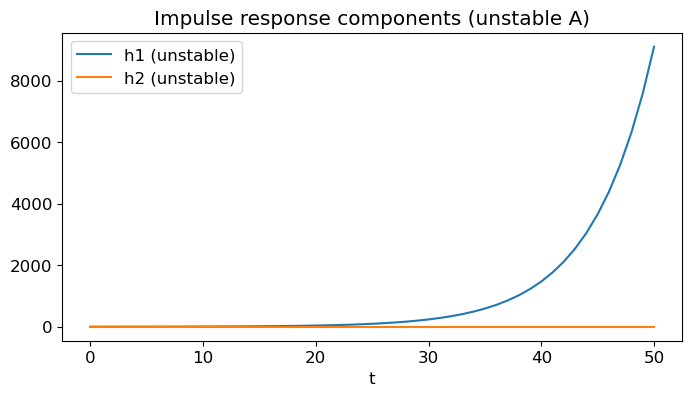

In [5]:
B = np.array([1.0, 0.0])  # single input into first hidden unit
H_stable = impulse_response(A_stable, B, steps=50)
H_unstable = impulse_response(A_unstable, B, steps=50)

plt.figure()
plt.plot(H_stable[:,0], label='h1 (stable)')
plt.plot(H_stable[:,1], label='h2 (stable)')
plt.title('Impulse response components (stable A)')
plt.xlabel('t')
plt.legend()
plt.show()

plt.figure()
plt.plot(H_unstable[:,0], label='h1 (unstable)')
plt.plot(H_unstable[:,1], label='h2 (unstable)')
plt.title('Impulse response components (unstable A)')
plt.xlabel('t')
plt.legend()
plt.show()


## Section 4 — Transfer-function (Z-domain) for linearized RNN

If the system has an output $y_t = C h_t$, then the transfer function from X(z) to Y(z) is $T(z)=C (zI - A)^{-1} B$.
We demonstrate a numeric evaluation of T(z) along the unit circle (frequency response).

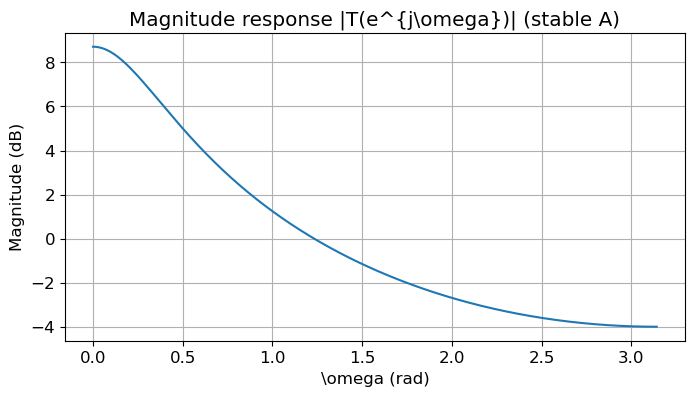

In [6]:
# choose C to observe first hidden unit
C = np.array([[1.0, 0.0]])

omegas = np.linspace(0, np.pi, 400)
Hz = []
for w in omegas:
    z = np.exp(1j*w)
    Tz = C @ inv(z*np.eye(A_stable.shape[0]) - A_stable) @ B
    Hz.append(Tz[0])
Hz = np.array(Hz)

plt.figure()
plt.plot(omegas, 20*np.log10(np.abs(Hz)))
plt.title('Magnitude response |T(e^{j\omega})| (stable A)')
plt.xlabel('\omega (rad)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()


## Section 5 — Spectral radius sweep (stability boundary)

Scale a base matrix W by alpha and plot spectral radius vs alpha to see when eigenvalues cross the unit circle.

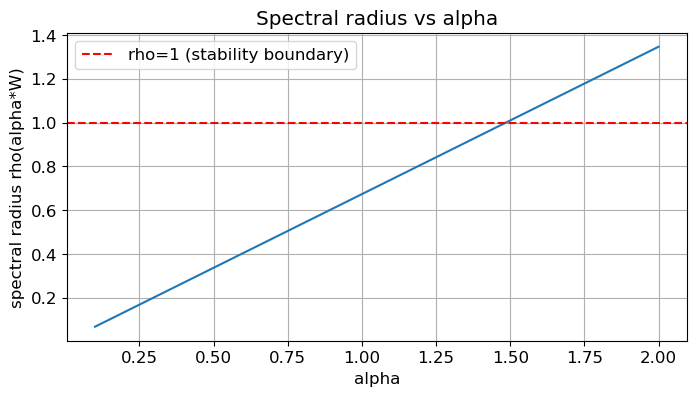

Approx critical alpha where rho crosses 1: 1.4940


In [7]:
W = np.array([[0.6, 0.2],[0.1, 0.4]])
alphas = np.linspace(0.1, 2.0, 200)
rhos = []
for a in alphas:
    rho, _ = spectral_radius(a*W)
    rhos.append(rho)

plt.figure()
plt.plot(alphas, rhos)
plt.axhline(1.0, color='red', linestyle='--', label='rho=1 (stability boundary)')
plt.xlabel('alpha')
plt.ylabel('spectral radius rho(alpha*W)')
plt.title('Spectral radius vs alpha')
plt.legend()
plt.grid(True)
plt.show()

crit_idx = np.where(np.array(rhos) >= 1.0)[0]
if crit_idx.size > 0:
    crit_alpha = alphas[crit_idx[0]]
    print(f"Approx critical alpha where rho crosses 1: {crit_alpha:.4f}")
else:
    print("rho < 1 for all tested alphas")

## Section 6 — Vanishing / Exploding gradient analysis 

Backpropagation through time involves repeated multiplications by A^T (or A). Norm growth of (A^T)^k controls gradient magnitude.

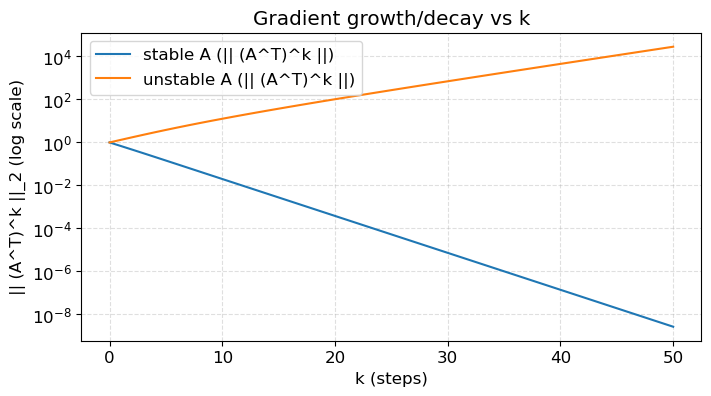

In [8]:
def power_norms(A, K=50):
    At = np.eye(A.shape[0])
    norms = [norm(At, ord=2)]
    for _ in range(K):
        At = At @ A.T
        norms.append(norm(At, ord=2))
    return np.array(norms)

K = 50
nrm_stable = power_norms(A_stable, K)
nrm_unstable = power_norms(A_unstable, K)

plt.figure()
plt.plot(nrm_stable, label='stable A (|| (A^T)^k ||)')
plt.plot(nrm_unstable, label='unstable A (|| (A^T)^k ||)')
plt.yscale('log')
plt.xlabel('k (steps)')
plt.ylabel('|| (A^T)^k ||_2 (log scale)')
plt.title('Gradient growth/decay vs k')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.show()

## Section 7 — Example: tiny param study showing all behaviors

Create a family of A matrices by scaling a base W and show representative trajectories and gradient norms.

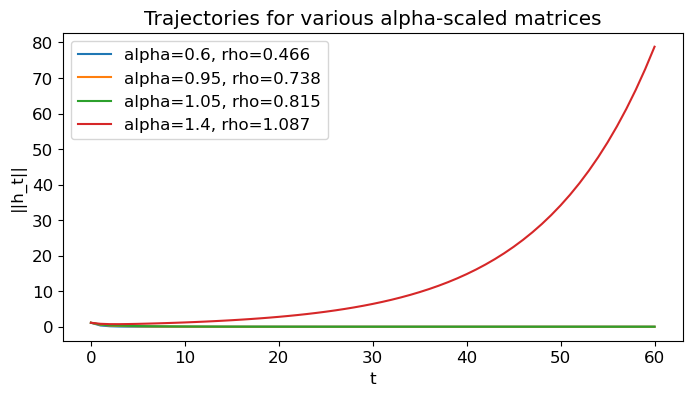

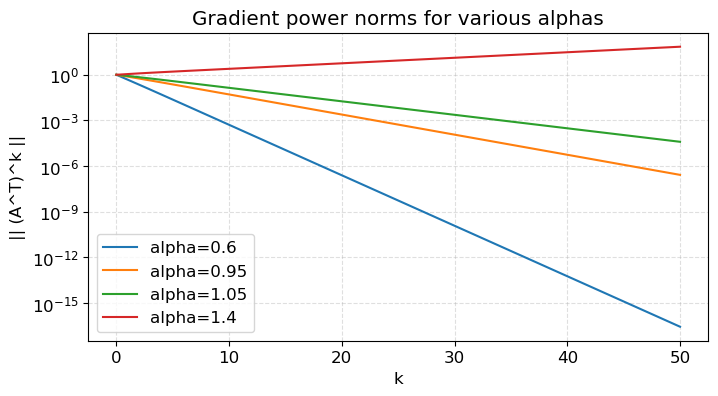

In [9]:
W = np.array([[0.7, 0.25],[0.1, 0.45]])
alphas = [0.6, 0.95, 1.05, 1.4]

plt.figure()
for a in alphas:
    A_try = a * W
    rho, eigs = spectral_radius(A_try)
    traj = simulate_homogeneous(A_try, np.array([1.0, -0.5]), steps=60)
    plt.plot(traj_norms(traj), label=f'alpha={a}, rho={rho:.3f}')
plt.xlabel('t')
plt.ylabel('||h_t||')
plt.title('Trajectories for various alpha-scaled matrices')
plt.legend()
plt.show()

plt.figure()
for a in alphas:
    A_try = a * W
    pn = power_norms(A_try, K=50)
    plt.plot(pn, label=f'alpha={a}')
plt.yscale('log')
plt.title('Gradient power norms for various alphas')
plt.xlabel('k')
plt.ylabel('|| (A^T)^k ||')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.show()

## Section 8 — Numerical checks for BIBO stability (practical tests)

Practical numerical checks: eigenvalues, impulse response partial sums, and relative increases.

A_stable: final running sum = 2.791, rel_inc(last10)=0.000e+00
A_unstable: final running sum = 41152901423574016.000, rel_inc(last10)=8.062e-01


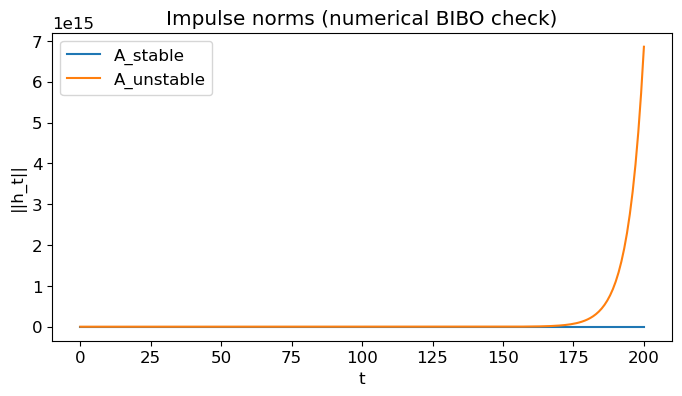

In [10]:
def numeric_bibo_check(A, B, steps=200):
    H = impulse_response(A, B, steps=steps)
    norms = np.linalg.norm(H, axis=1)
    running_sum = np.cumsum(np.abs(norms))
    rel_inc = (running_sum[-1] - running_sum[-10]) / (running_sum[-1] + 1e-12)
    return norms, running_sum, rel_inc

B = np.array([1.0, 0.0])
for A_try, name in [(A_stable, 'A_stable'), (A_unstable, 'A_unstable')]:
    norms, running_sum, rel_inc = numeric_bibo_check(A_try, B, steps=200)
    print(f"{name}: final running sum = {running_sum[-1]:.3f}, rel_inc(last10)={rel_inc:.3e}")
    plt.plot(norms, label=name)
plt.yscale('linear')
plt.title('Impulse norms (numerical BIBO check)')
plt.xlabel('t')
plt.ylabel('||h_t||')
plt.legend()
plt.show()

## Section 9 — effect of simple nonlinear activation (heuristic)

A nonlinear activation like `tanh` saturates; the nonlinear system can behave differently globally but linearization still describes local dynamics.

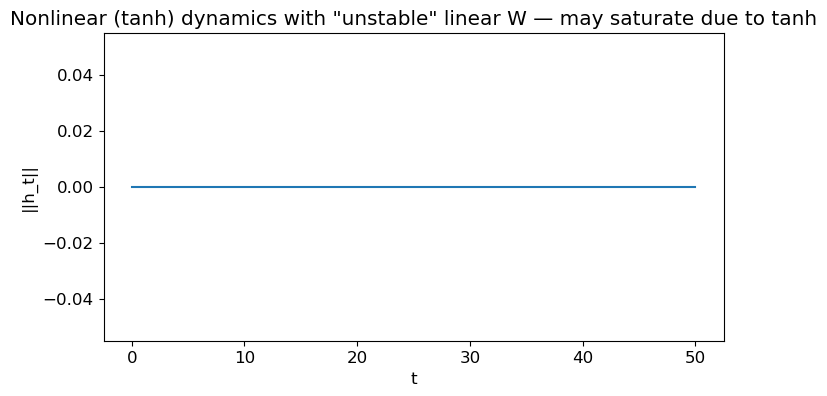

In [11]:
def simulate_nonlinear(W, B, x_seq, h0=None, steps=100, nonlin=np.tanh):
    n = W.shape[0]
    if h0 is None:
        h = np.zeros(n)
    else:
        h = h0.copy()
    H = [h.copy()]
    for t in range(steps):
        u = x_seq[t] if t < len(x_seq) else 0.0
        h = nonlin(W @ h + B * u)
        H.append(h.copy())
    return np.array(H)

W_nl = np.array([[1.2, 0.3], [0.0, 1.1]])
B_nl = np.array([0.5, 0.0])
H_nl = simulate_nonlinear(W_nl, B_nl, x_seq=[0]*50, steps=50)
plt.plot(traj_norms(H_nl))
plt.title('Nonlinear (tanh) dynamics with "unstable" linear W — may saturate due to tanh')
plt.xlabel('t')
plt.ylabel('||h_t||')
plt.show()

## Section 10 — Conclusion 

**Conclusion (short):** For RNNs linearized about an operating point, BIBO stability and transfer-function analysis are identical to discrete-time LTI systems: check the spectral radius of the state matrix. The math also explains vanishing/exploding gradients via powers of the state matrix.






In [12]:
import numpy as np
from numpy.linalg import eigvals

np.random.seed(0)

def scale_to_spectral_radius(W, target_rho):
    eigs = eigvals(W)
    cur_rho = np.max(np.abs(eigs))
    return (target_rho / cur_rho) * W

# Hidden dimension
n = 3

# Stable matrix → spectral radius ≈ 0.8
W_stable = scale_to_spectral_radius(np.random.randn(n, n), 0.8)

# Marginal matrix → eigenvalue exactly 1
W_marginal = np.diag([1.0, 0.98, 0.95])

# Unstable matrix → spectral radius ≈ 1.2
W_unstable = scale_to_spectral_radius(np.random.randn(n, n), 1.2)

Ws = {
    "stable": W_stable,
    "marginal": W_marginal,
    "unstable": W_unstable
}


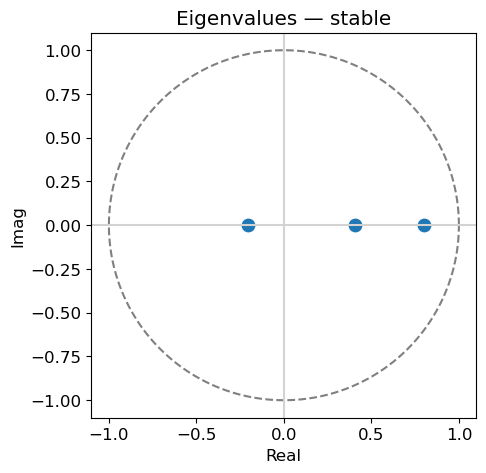

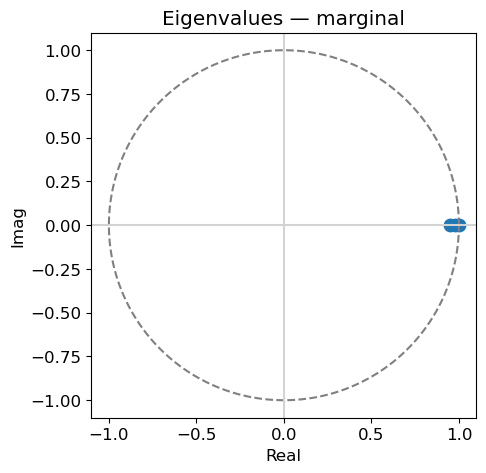

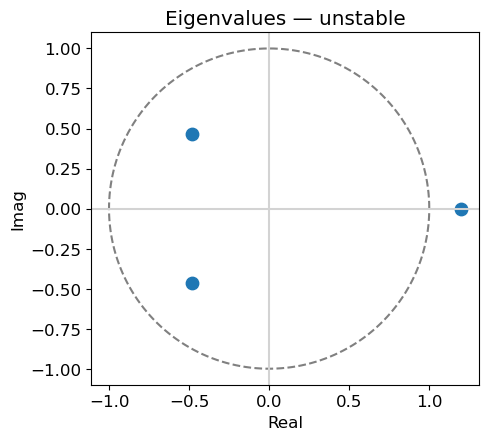

In [13]:
import matplotlib.pyplot as plt

def plot_eigs(W, title):
    eigs = eigvals(W)
    theta = np.linspace(0, 2*np.pi, 400)

    plt.figure(figsize=(5,5))
    plt.plot(np.cos(theta), np.sin(theta), '--', color='gray')   # unit circle
    plt.scatter(eigs.real, eigs.imag, s=80)
    plt.axhline(0, color='lightgray')
    plt.axvline(0, color='lightgray')
    plt.gca().set_aspect('equal', 'box')
    plt.title(title)
    plt.xlabel('Real')
    plt.ylabel('Imag')
    plt.show()

for name, W in Ws.items():
    plot_eigs(W, f"Eigenvalues — {name}")


In [14]:
T = 200
h0 = np.array([0.5, -0.3, 0.2])      # non-zero initial state
input_dim = 1
B = np.ones((n, input_dim))         # simple input mapping

# bounded random input
use_bounded_input = True
if use_bounded_input:
    x_seq = np.random.uniform(-1, 1, (T, input_dim))
else:
    x_seq = np.zeros((T, input_dim))

def simulate(W, B, x_seq, h0, T):
    H = np.zeros((T+1, len(h0)))
    H[0] = h0.copy()
    for t in range(T):
        H[t+1] = W @ H[t] + (B @ x_seq[t])
    return H


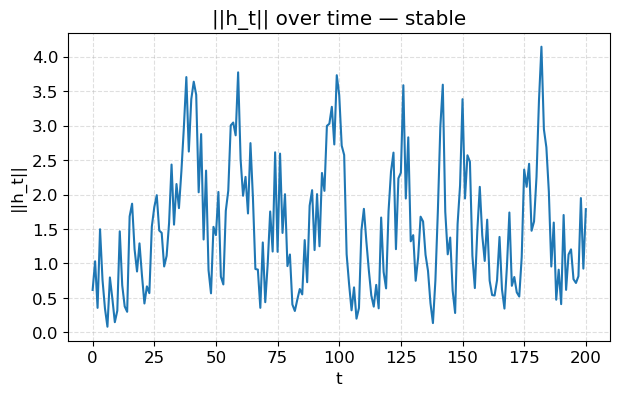

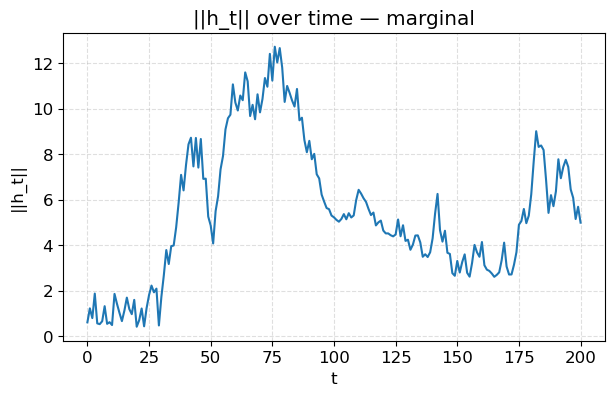

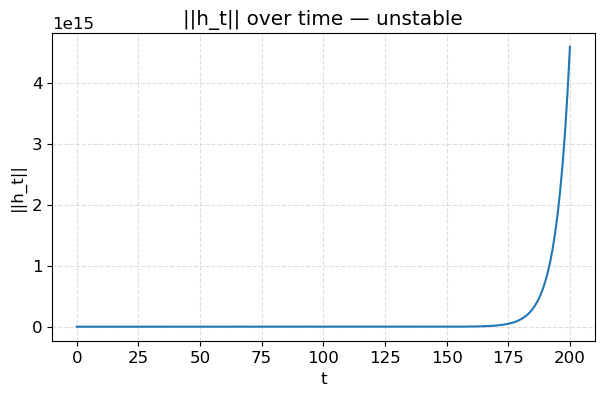

In [15]:
def plot_state_norms(W, name):
    H = simulate(W, B, x_seq, h0, T)
    norms = np.linalg.norm(H, axis=1)

    plt.figure(figsize=(7,4))
    plt.plot(norms)
    plt.title(f"||h_t|| over time — {name}")
    plt.xlabel("t")
    plt.ylabel("||h_t||")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()

for name, W in Ws.items():
    plot_state_norms(W, name)


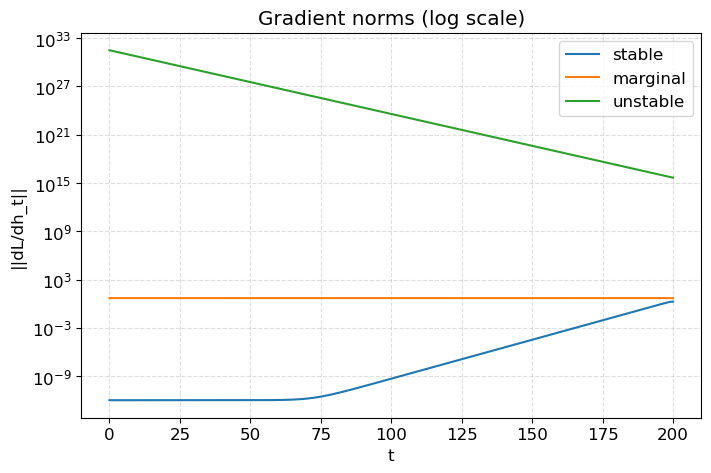

In [16]:
def gradient_norms(W, H, target):
    T = H.shape[0] - 1
    err = H[-1] - target
    norms = np.zeros(T+1)

    M = np.eye(W.shape[0])
    norms[T] = np.linalg.norm(err)

    for k in range(1, T+1):
        M = M @ W.T
        grad = M @ err
        norms[T-k] = np.linalg.norm(grad)

    return norms

target = np.zeros(n)

plt.figure(figsize=(8,5))
for name, W in Ws.items():
    H = simulate(W, B, x_seq, h0, T)
    gnorms = gradient_norms(W, H, target)
    plt.semilogy(gnorms + 1e-12, label=name)

plt.title("Gradient norms (log scale)")
plt.xlabel("t")
plt.ylabel("||dL/dh_t||")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.show()
